In [2]:
# Load required packages
library(tidyverse)
library(broom)
library(yardstick)
library(rpart)
library(rpart.plot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘yardstick’


The following object is masked from ‘package:readr’:

    spec




In [3]:
# import GoalZone data as GZ
GZ <- read.csv("fitness_class_2212.csv")
GZ

str(GZ)

booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
1,17,79.56,8,Wed,PM,Strength,0
2,10,79.01,2,Mon,AM,HIIT,0
3,16,74.53,14,Sun,AM,Strength,0
4,5,86.12,10,Fri,AM,Cycling,0
5,15,69.29,8,Thu,AM,HIIT,0
6,7,93.33,2,Mon,AM,Cycling,0
7,11,88.59,6,Wednesday,PM,HIIT,0
8,9,89.52,10,Fri,AM,HIIT,0
9,23,71.12,10,Fri.,AM,HIIT,1


'data.frame':	1500 obs. of  8 variables:
 $ booking_id      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ months_as_member: int  17 10 16 5 15 7 11 9 23 7 ...
 $ weight          : num  79.6 79 74.5 86.1 69.3 ...
 $ days_before     : chr  "8" "2" "14" "10" ...
 $ day_of_week     : chr  "Wed" "Mon" "Sun" "Fri" ...
 $ time            : chr  "PM" "AM" "AM" "AM" ...
 $ category        : chr  "Strength" "HIIT" "Strength" "Cycling" ...
 $ attended        : int  0 0 0 0 0 0 0 0 1 0 ...


In [4]:
# Investigate data structure and variable types and clean it up to match with the instructions

# Check the number of missing values (NA, NULL, NaN) in the data
sum(is.na(GZ))
sum(is.null(GZ))
sum(apply(GZ, 2, is.nan))

# Columnwise summary of NA values
apply(is.na(GZ), MARGIN = 2, FUN = sum)

# Replace NA values in the weight column with the average weight
min(GZ$weight, na.rm = TRUE) # Make sure the min value is not below 40
round(mean(GZ$weight, na.rm = TRUE), digits = 2) # calculate mean

#Checking if there are other unusual charachers as missing values
unique(GZ$category)
unique(GZ$days_before)
unique(GZ$day_of_week)
unique(GZ$time)

# Data cleaning
GZ1 <- GZ |> 
mutate(weight = ifelse(is.na(weight), 82.61, weight)) |>
mutate(category = str_replace(category,"-","unknown")) |>
mutate(days_before = as.numeric(str_remove(days_before, "days"))) |>
mutate(day_of_week = recode(day_of_week, "Wednesday" = "Wed", "Monday" = "Mon", "Fri." = "Fri")) |>
mutate(day_of_week = factor(day_of_week, 
							levels = c("Sun","Mon","Tue","Wed","Thu","Fri","Sat"))) |>
mutate(time = as.factor(time)) |>
mutate(attended = as.factor(attended))

# Observe the data structure again for any discrepancies
sum(is.na(GZ1))
unique(GZ1$days_before)
unique(GZ1$day_of_week)

# Checking rank order in the data
levels(GZ1$time)
levels(GZ1$day_of_week)

[1] 20

[1] 0

[1] 0

booking_id months_as_member           weight      days_before 
               0                0               20                0 
     day_of_week             time         category         attended 
               0                0                0                0

[1] 55.41

[1] 82.61

[1] "Strength" "HIIT"     "Cycling"  "Yoga"     "-"        "Aqua"

[1] "8"       "2"       "14"      "10"      "6"       "4"       "9"      
 [8] "12"      "5"       "3"       "7"       "13"      "12 days" "20"     
[15] "1"       "15"      "6 days"  "11"      "13 days" "3 days"  "16"     
[22] "1 days"  "7 days"  "8 days"  "10 days" "14 days" "17"      "5 days" 
[29] "2 days"  "4 days"  "29"

[1] "Wed"       "Mon"       "Sun"       "Fri"       "Thu"       "Wednesday"
 [7] "Fri."      "Tue"       "Sat"       "Monday"

[1] "PM" "AM"

[1] 0

[1]  8  2 14 10  6  4  9 12  5  3  7 13 20  1 15 11 16 17 29

[1] Wed Mon Sun Fri Thu Tue Sat
Levels: Sun Mon Tue Wed Thu Fri Sat

[1] "AM" "PM"

[1] "Sun" "Mon" "Tue" "Wed" "Thu" "Fri" "Sat"

booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
<int>,<int>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<fct>
1,17,79.56,8,Wed,PM,Strength,0
2,10,79.01,2,Mon,AM,HIIT,0
3,16,74.53,14,Sun,AM,Strength,0
4,5,86.12,10,Fri,AM,Cycling,0
5,15,69.29,8,Thu,AM,HIIT,0
6,7,93.33,2,Mon,AM,Cycling,0
7,11,88.59,6,Wed,PM,HIIT,0
8,9,89.52,10,Fri,AM,HIIT,0
9,23,71.12,10,Fri,AM,HIIT,1


[1] 1500

attended,total
<fct>,<int>
0,1046
1,454


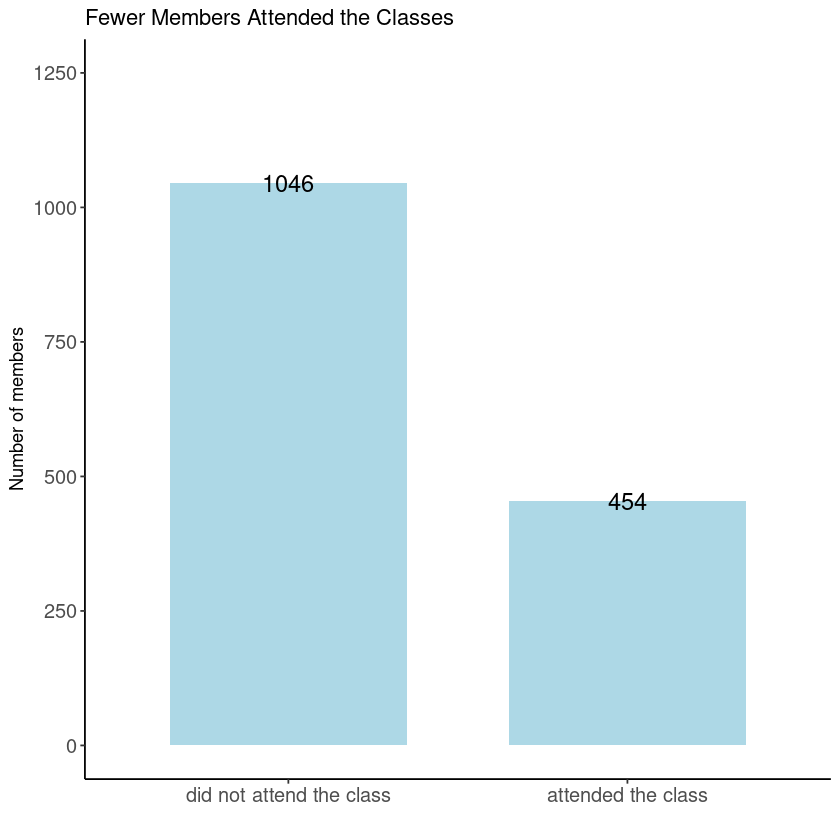

In [4]:
GZ1
nrow(GZ1)
attendance <- GZ1 |>
group_by(attended) |>
summarise(total = n())
attendance

# Visualize the attendance numbers

howmany  <- attendance |>
ggplot(aes(x = factor(attended), y = total)) +
geom_col(fill = "lightblue", width = 0.7) +
scale_y_continuous(limits = c(0, 1250),
				  breaks = seq(0, 1250, 250)) +
scale_x_discrete(labels = c("did not attend the class", "attended the class")) +
labs(x = "",
	y = "Number of members",
	title = "Fewer Members Attended the Classes") +
theme_classic() +
theme(axis.text = element_text(size = 12)) +
geom_text(aes(label = total), size = 5)

howmany

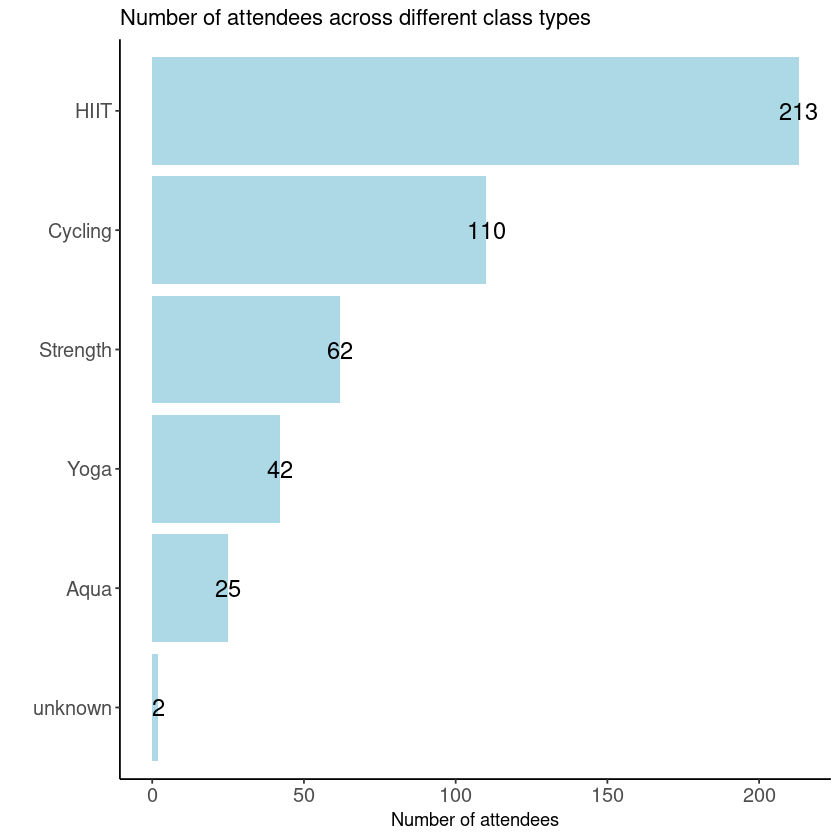

In [5]:
# Visualize attendees across the categories

fitnessclass <- GZ1 |>
filter(attended == 1) |>
group_by(category) |>
summarize(total = n())

fitnessclass |>
ggplot(aes(x = reorder(category, +total), y = total)) +
geom_col(fill = "lightblue") +
labs(x = "",
	y = "Number of attendees",
	title = "Number of attendees across different class types") +
geom_text(aes(label = total), size = 5) +
coord_flip() +
theme_classic() +
theme(axis.text = element_text(size = 12))


The distribution of the number of months as a member. 

Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


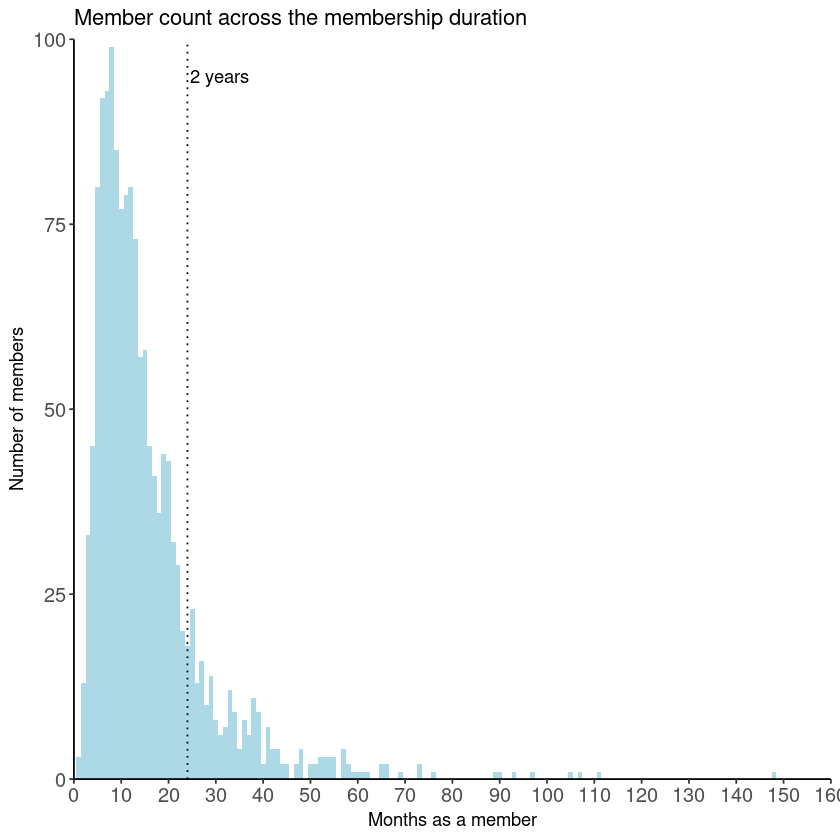

In [6]:
GZ1 |>
ggplot(aes(x = months_as_member)) +
geom_histogram(binwidth = 1, fill = "lightblue") +
coord_cartesian(expand = FALSE, clip = "off") +
scale_x_continuous(limits = c(0, 160),
				  breaks = seq(0, 160, 10)) +
scale_y_continuous(limits = c(0, 100)) +
geom_vline(xintercept = 24, color = "black", linetype = "dotted") +
labs(x = "Months as a member",
	y = "Number of members",
	title = "Member count across the membership duration") +
theme_classic() +
theme(axis.text = element_text(size = 12)) +
annotate(geom = "text", x = 24.5, y = 95, label = "2 years", hjust = 0)

The relationship between attendance and number of months as a member.


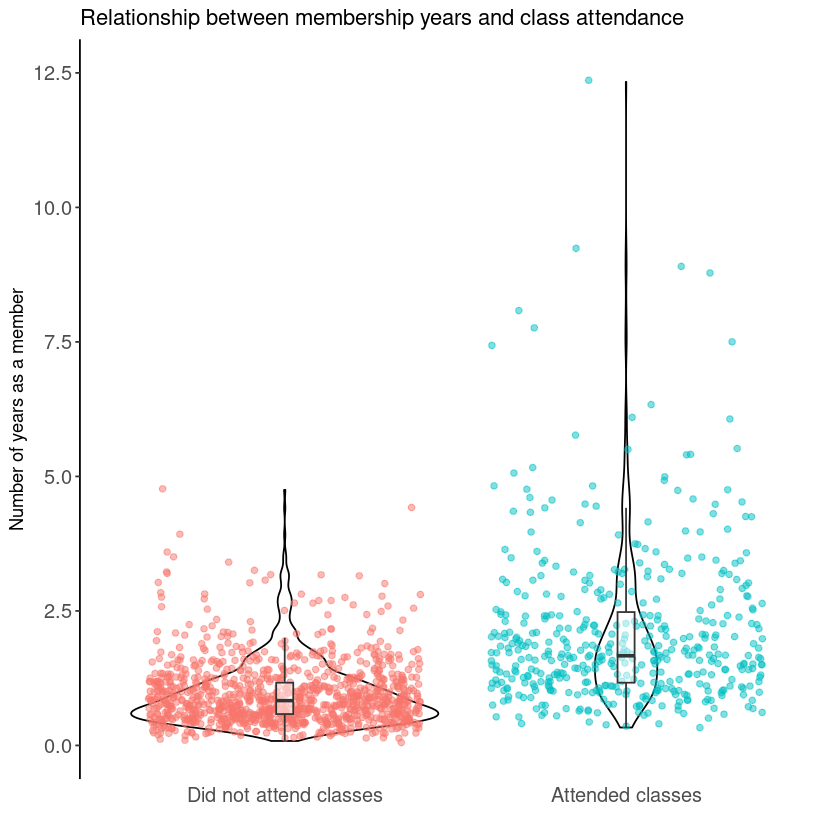

In [21]:
attendance_vs_months <- GZ1 |>
mutate(years_as_member = months_as_member/12) |>
ggplot(aes(x = factor(attended), y = years_as_member)) +
geom_violin(color = "black", scale = "count") +
geom_point(aes(color = factor(attended)),position = "jitter", alpha = 0.5) +
geom_boxplot(width = 0.05, outlier.color = NA, alpha = 0.5) +
scale_y_continuous(limits = c(0, 12.5),
				  breaks = seq(0, 12.5, 2.5)) +
scale_x_discrete(breaks = c(0,1),
				 labels = c('Did not attend classes', 'Attended classes')) +
labs(x = "",
	y = "Number of years as a member",
	title = "Relationship between membership years and class attendance") +
theme_classic() +
theme(axis.text = element_text(size = 12),
	 axis.line.x = element_blank(),
	 axis.ticks.x = element_blank(),
	 legend.position = "none")

attendance_vs_months

In [26]:
# Run a statistical test - Did attendees hold membership for longer?

GZ1_attendees <- GZ1 |>
filter(attended == 1) |>
select(months_as_member)

GZ1_attendees

GZ1_absentee <- GZ1 |>
filter(attended == 0) |>
select(months_as_member)

GZ1_absentee

# Check if data is normally distributed using Shapiro-Wilk normality test 
shapiro.test(GZ1_attendees$months_as_member)
shapiro.test(GZ1_absentee$months_as_member)

# p-values dor both groups are < 0.05 suggesting data is not normally distributed.
# Run a non-parametric test

wilcox.test(GZ1_attendees$months_as_member, GZ1_absentee$months_as_member)


months_as_member
<int>
23
16
9
22
33
10
24
14
12


months_as_member
<int>
17
10
16
5
15
7
11
9
7



	Shapiro-Wilk normality test

data:  GZ1_attendees$months_as_member
W = 0.79108, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  GZ1_absentee$months_as_member
W = 0.85847, p-value < 2.2e-16



	Wilcoxon rank sum test with continuity correction

data:  GZ1_attendees$months_as_member and GZ1_absentee$months_as_member
W = 390518, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



To predict whether members will attend using the data provided, we use
machine learning classification method where one or more variables determine the outcome.



Fit a baseline model to predict whether members will attend using the data provided. 
Several variables could determine the outcome, such as weight, day of the week, time, and months as a member. However, the relationship between outcome vs months as a member suggest a strong relationship between the two variables (task 4). Taking this information alone, months as a member could be a strong predictor of whether members will attend the classes. 
Therefore, I first created a simple logistic regression model with a single explanatory variable. 

- The model showed 78% accuracy in predicting the outcome with 93% sensititivy. However, the specificity was less than 50%.
- Adding weight or day of the week as a variable in addition to months as a member does not change model accuracy, sensititvity, specificity and precision.

Therefore, membership duration is a good predictor of outcome making the *attended_vs_months* a good baseline model. 


Call:
glm(formula = attended ~ months_as_member, family = binomial, 
    data = GZ1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9653  -0.6757  -0.5041   0.5453   2.2228  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -2.892648   0.145094  -19.94   <2e-16 ***
months_as_member  0.127664   0.008147   15.67   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1839.3  on 1499  degrees of freedom
Residual deviance: 1417.2  on 1498  degrees of freedom
AIC: 1421.2

Number of Fisher Scoring iterations: 5


                  actual_response
predicted_response   0   1
                 0 976 261
                 1  70 193

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7793333
kap,binary,0.4065945
sens,binary,0.4251101
spec,binary,0.9330784
ppv,binary,0.7338403
npv,binary,0.7890057
mcc,binary,0.4327556
j_index,binary,0.3581885
bal_accuracy,binary,0.6790943


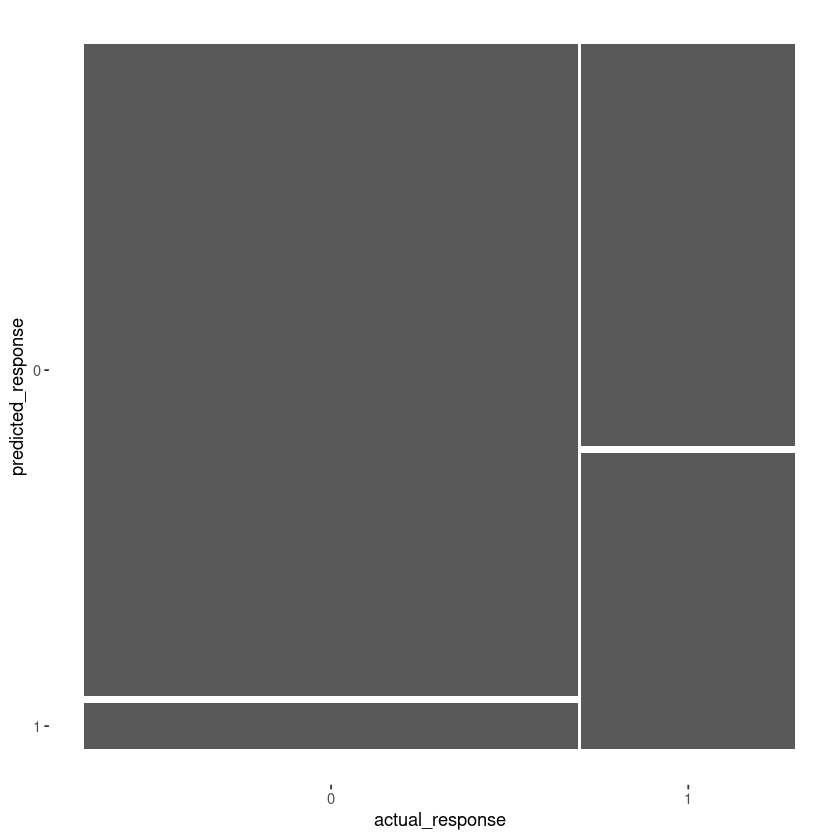

In [66]:
# Apply a logistic regression model using weight as an months as member variable

attended_vs_months <- glm(formula = attended ~ months_as_member,
						 data = GZ1,
						 family = binomial)

summary(attended_vs_months)

# Evaluate model accuracy + Specificity + Sensitivity

actual_response <- GZ1$attended
predicted_response <- round(fitted(attended_vs_months))

Outcomes <- table(predicted_response, actual_response)
Outcomes

# Visualize the outcome
confusion <- conf_mat(Outcomes)
autoplot(confusion)

# Model Performance matrix

summary(confusion, event_level = "second")


Call:
glm(formula = attended ~ months_as_member + weight, family = binomial, 
    data = GZ1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9208  -0.6846  -0.5043   0.5585   2.2443  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -2.091244   0.615226  -3.399 0.000676 ***
months_as_member  0.122095   0.009046  13.497  < 2e-16 ***
weight           -0.008819   0.006626  -1.331 0.183210    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1839.3  on 1499  degrees of freedom
Residual deviance: 1415.4  on 1497  degrees of freedom
AIC: 1421.4

Number of Fisher Scoring iterations: 5


                         actual_response_weight
predicted_response_weight   0   1
                        0 977 263
                        1  69 191

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7786667
kap,binary,0.4035357
sens,binary,0.4207048
spec,binary,0.9340344
ppv,binary,0.7346154
npv,binary,0.7879032
mcc,binary,0.4305321
j_index,binary,0.3547393
bal_accuracy,binary,0.6773696


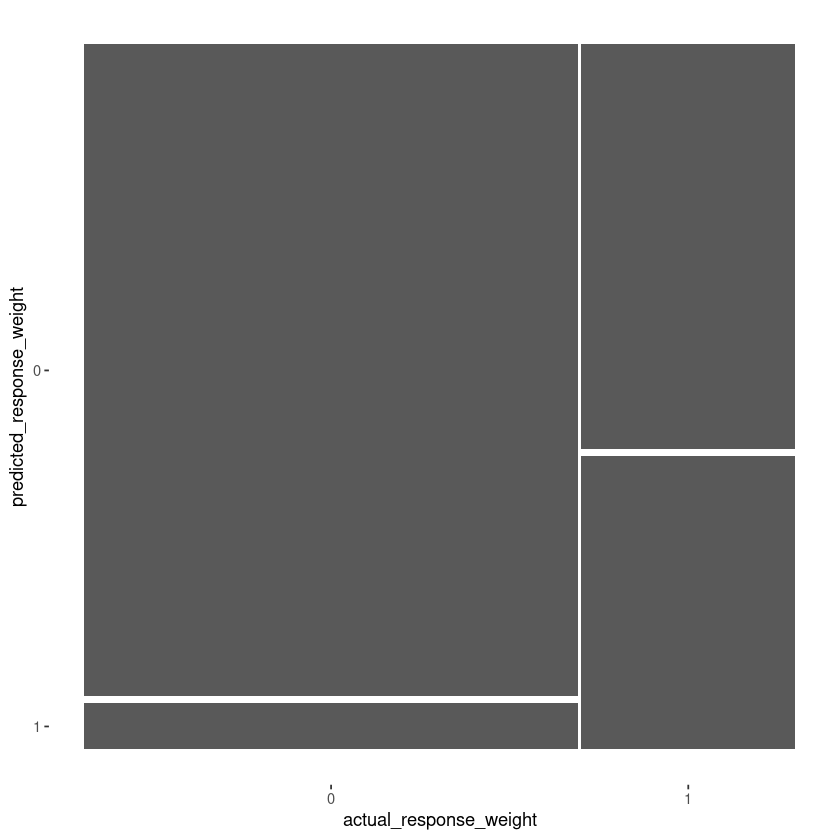

In [67]:
# Add weight as a predictor
attended_vs_months_weight <- glm(formula = attended ~ months_as_member + weight,
						 data = GZ1,
						 family = binomial)

summary(attended_vs_months_weight)

# Evaluate model accuracy + Specificity + Sensitivity

actual_response_weight <- GZ1$attended
predicted_response_weight <- round(fitted(attended_vs_months_weight))

Outcomes_weight <- table(predicted_response_weight, actual_response_weight)
Outcomes_weight

# Visualize the outcome
confusion_weight <- conf_mat(Outcomes_weight)
autoplot(confusion_weight)

# Model Performance matrix
summary(confusion_weight, event_level = "second")


Call:
glm(formula = attended ~ months_as_member + day_of_week, family = binomial, 
    data = GZ1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9617  -0.6691  -0.4971   0.5545   2.2834  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -2.660620   0.209076 -12.726  < 2e-16 ***
months_as_member  0.128614   0.008181  15.721  < 2e-16 ***
day_of_weekMon   -0.290327   0.241320  -1.203  0.22895    
day_of_weekTue   -0.268388   0.252487  -1.063  0.28779    
day_of_weekWed   -0.898593   0.327280  -2.746  0.00604 ** 
day_of_weekThu   -0.065375   0.233240  -0.280  0.77925    
day_of_weekFri   -0.297195   0.225210  -1.320  0.18696    
day_of_weekSat   -0.275432   0.248273  -1.109  0.26726    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1839.3  on 1499  degrees of freedom
Residual deviance: 1407.6  on 1492  degrees of freedom
AIC:

                      actual_response_day
predicted_response_day   0   1
                     0 976 254
                     1  70 200

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7840000
kap,binary,0.4220066
sens,binary,0.4405286
spec,binary,0.9330784
ppv,binary,0.7407407
npv,binary,0.7934959
mcc,binary,0.4467601
j_index,binary,0.3736070
bal_accuracy,binary,0.6868035


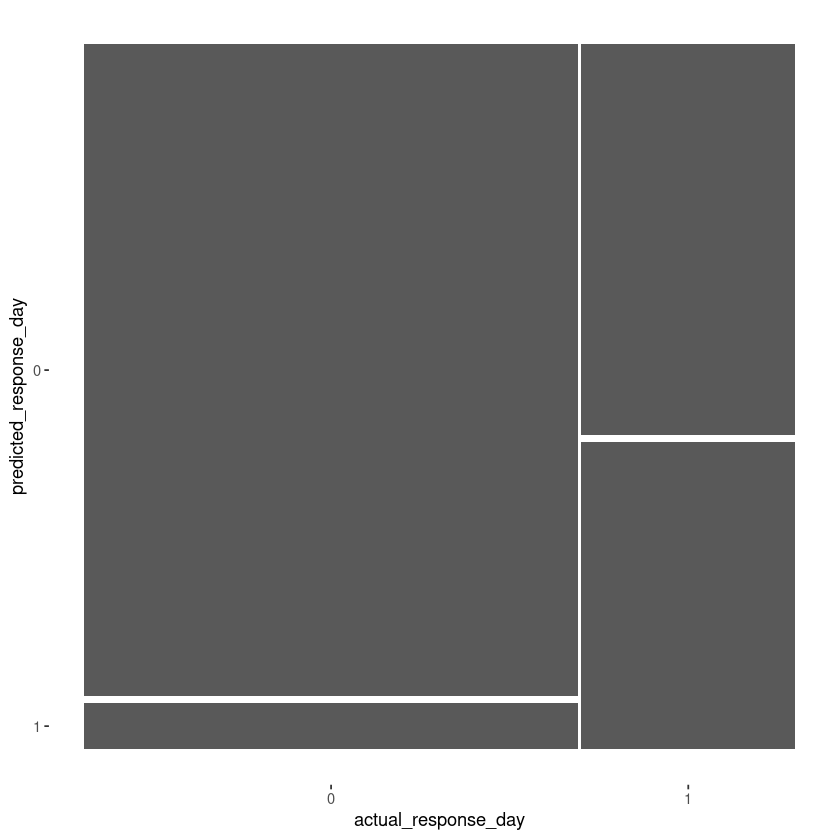

In [68]:
# Add days of the week instead of weight as a predictor

attended_vs_months_day <- glm(formula = attended ~ months_as_member + day_of_week,
						 data = GZ1,
						 family = binomial)

summary(attended_vs_months_day)

# Evaluate model accuracy + Specificity + Sensitivity

actual_response_day <- GZ1$attended
predicted_response_day <- round(fitted(attended_vs_months_day))

Outcomes_day <- table(predicted_response_day, actual_response_day)
Outcomes_day

# Visualize the outcome
confusion_day <- conf_mat(Outcomes_day)
autoplot(confusion_day)

# Model Performance matrix
summary(confusion_day, event_level = "second")


Fit a comparison model to predict whether members will attend using the data
provided.

The baseline logistic regression show good accuracy with a single explanatory variable. The decision tree model includes additional features to evaluate model performance with the goal of improving outcome prediction. Therefore, I chose all the variables as explanatory variables to develop a model.


In [69]:
# Split data into train and test datasets

set.seed(500)
ind <- sample(2, nrow(GZ1), replace = TRUE, prob = c(0.7, 0.3))
train_data <- GZ1[ind==1,]
test_data <- GZ1[ind==2,]

dim(train_data)
dim(test_data)

[1] 1042    8

[1] 458   8

n= 1042 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 1042 310 0 (0.7024952 0.2975048)  
    2) months_as_member< 15.5 680  94 0 (0.8617647 0.1382353) *
    3) months_as_member>=15.5 362 146 1 (0.4033149 0.5966851)  
      6) months_as_member< 23.5 194  92 0 (0.5257732 0.4742268)  
       12) day_of_week=Mon,Wed,Sat 67  25 0 (0.6268657 0.3731343) *
       13) day_of_week=Sun,Tue,Thu,Fri 127  60 1 (0.4724409 0.5275591)  
         26) time=PM 19   6 0 (0.6842105 0.3157895) *
         27) time=AM 108  47 1 (0.4351852 0.5648148)  
           54) weight>=74.86 65  32 0 (0.5076923 0.4923077)  
            108) weight< 76.13 7   0 0 (1.0000000 0.0000000) *
            109) weight>=76.13 58  26 1 (0.4482759 0.5517241)  
              218) day_of_week=Fri 21   7 0 (0.6666667 0.3333333) *
              219) day_of_week=Sun,Tue,Thu 37  12 1 (0.3243243 0.6756757) *
           55) weight< 74.86 43  14 1 (0.3255814 0.6744186) *
      7) months_as_member>=23.5 168  4

[1] 0.806142

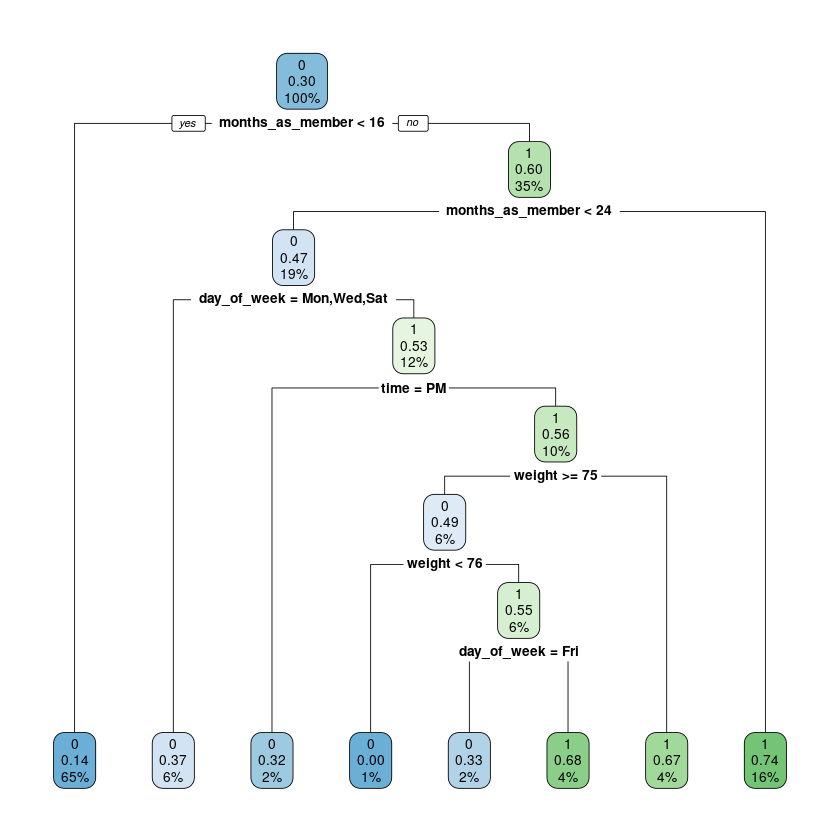

In [70]:
# Build a simple decision tree

dt_model <- rpart(attended ~ ., 
						data = train_data,
						method = "class")
dt_model

rpart.plot(dt_model)

rf_model_p <- predict(dt_model,
					 data = test_data,
					 type = "class")

# Evaluate model accuracy

mean(rf_model_p == train_data$attended)

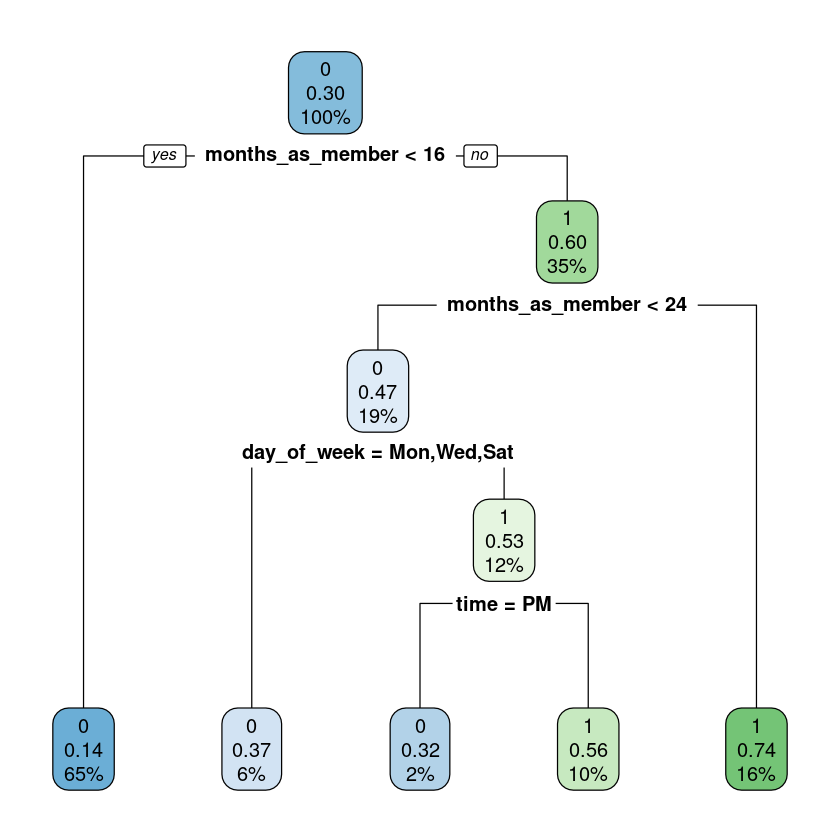

[1] 0.7927063

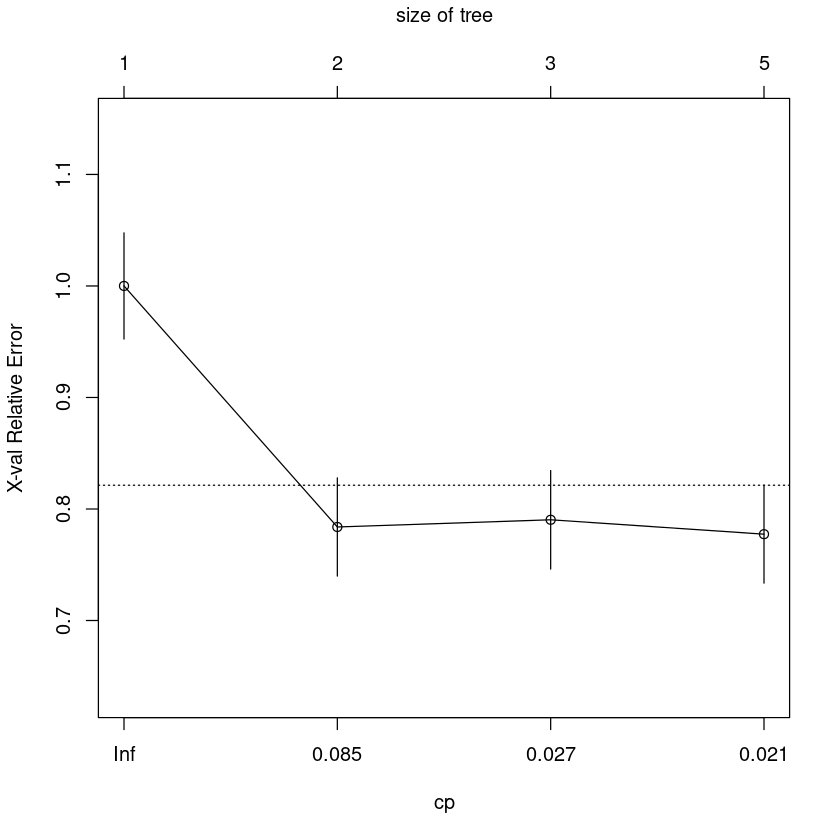

In [71]:
# Build a simple decision tree with complexity penalty (create a simpler tree to make sure data is not overfitted)

dt_model_cp <- rpart(attended ~ ., 
						data = train_data,
						method = "class",
				 control = rpart.control(cp = 0.02))

rpart.plot(dt_model_cp)
plotcp(dt_model_cp)

rf_model_p_cp <- predict(dt_model_cp,
					 data = test_data,
					 type = "class")

# Evaluate model accuracy

mean(rf_model_p_cp == train_data$attended)

**CONCLUSION**

**Both models perform with relatively similar accuracy (~ 80%).** 
- In the simple logistic regression, single explanatory variable alone creates a model with great accuracy.
- In the decision tree, both pruned and unpruned models show similar accuracy (~ 80%). However, the decision tree takes into account day_of_week and weight variable to accurately predict the outcome, that could improve predictions in future _data._